# Training und Verifikation mittels MILP von Netz auf CIFAR10 Datensatz
Es sollte bereits ein trainiertes Netz existieren.

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.Networks import *
from script.NeuralNets.trainFunction import train_sequential
from script.Verification.Verifier import MILPVerifier
import time
from jupyterthemes import jtplot
import gurobipy as grp
from gurobipy import GRB, max_
import script.Verification.VerificationBasics as verbas

load_model = True
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)



In [2]:
transform = Compose([ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                    )

training_data = CIFAR10(root="../../cifar",
                        train=True,
                        download=True,
                        transform=transform)

test_data = CIFAR10(root="../../cifar",
                    train=False,  # test set, 10k images
                    download=True,
                    transform=transform)

batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True)

classes = training_data.classes


def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"""model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
"""

model = SequentialNN([32 * 32 * 3, 1024, 512, 10])

if load_model:
    model.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
else:
    train_sequential(model, train_dataloader, test_dataloader, epochs=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


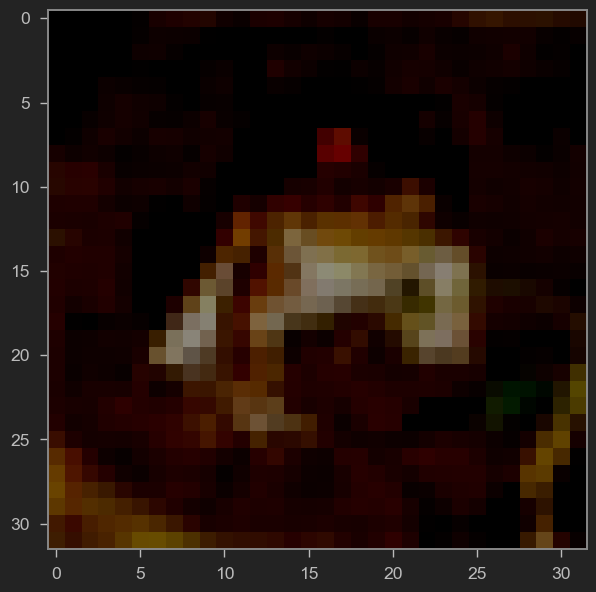

label is frog with index 6
prediction is frog with output tensor([[ 1.3665, -0.5882,  0.1332,  1.2625,  1.8794,  0.4330,  3.5173,  0.8659,
         -5.1264, -2.9051]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


In [4]:
images, labels = training_data.__getitem__(0)
testimage, testlabel = torch.unsqueeze(images, 0).to(torch.float64), torch.unsqueeze(torch.tensor(labels), 0).to(torch.float64)
imshow(images)
print("label is {} with index {}".format(classes[labels], labels))
pred = model(testimage)

print("prediction is {} with output {} ".format(classes[pred.argmax()], pred))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
Set parameter BestObjStop to value 0.001
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13843 rows, 7700 columns and 3695141 nonzeros
Model fingerprint: 0xca28b5b8
Model has 1 general constraint
Variable types: 6164 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [9e-11, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [3e-05, 6e+01]
Presolve added 0 rows and 6 columns
Presolve removed 7674 rows and 0 columns
Presolve time: 4.75s
Presolved: 6169 rows, 7706 columns, 3683818 nonzeros
Variable types: 6162 continuous, 1544 integer (1544 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

C:\Users\Ufuk\AppData\Local\Temp\ipykernel_11880\3870000522.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  test_inp = torch.tensor([inp], dtype=torch.float64)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.7258888619531945
-0.7341443572161097
0.2994708246221762
-0.3402062800207659
2.628970428084358
-0.6603496604865313
1.386720505757694
-3.9847485213656455
-2.8738175244218382
optimum solution with value 
 [ 3.86018179 -0.59985143  0.43376375 -0.20591336  2.76326335 -0.52605674
  0.13429292  1.52101343 -3.8504556  -2.7395246 ]
max_var 3.7258888619531945

time to solve 33.47466158866882 s.
tensor([[-0.4373, -0.7627, -0.7078,  ...,  0.0499, -0.2412, -0.5353]],
       dtype=torch.float64)
prediction is airplane with output tensor([[ 3.8602, -0.5999,  0.4338, -0.2059,  2.7633, -0.5261,  0.1343,  1.5210,
         -3.8505, -2.7395]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


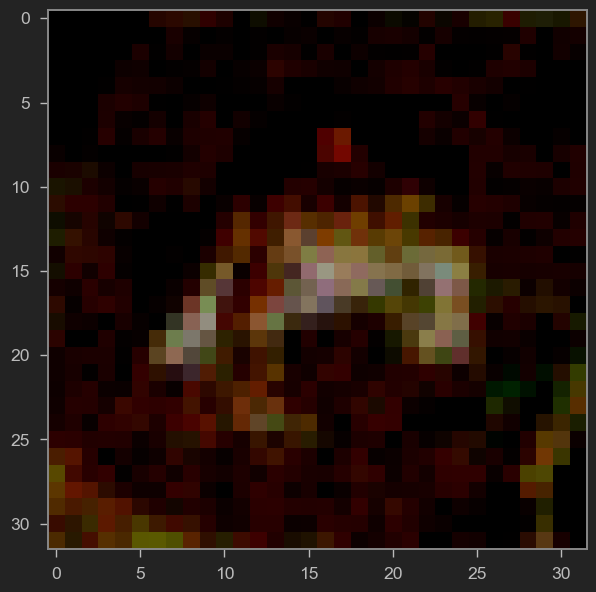

In [5]:
print("=================")
start = time.time()
verifier = MILPVerifier(model, testimage, 0.1, solver_bound=0.001, print_log=True)
verifier.generate_constraints_for_net()
output_var = verifier.output_vars
m = verifier.model
input_var = verifier.input_vars

difference = m.addVars(9, lb=-float('inf'))
m.addConstrs(difference[i] == output_var.tolist()[i] - output_var.tolist()[labels] for i in range(0, labels))
m.addConstrs(difference[i - 1] == output_var.tolist()[i] - output_var.tolist()[labels] for i in range(labels + 1, 10))

# m.addConstrs(difference[i] == output_var.tolist()[i] - output_var.tolist()[label] for i in range(10))
max_var = m.addVar(lb=-float('inf'), ub=10)
m.addConstr(max_var == max_(difference))

m.update()
m.setObjective(max_var, GRB.MAXIMIZE)
m.optimize()

if m.Status == GRB.OPTIMAL or m.Status == GRB.TIME_LIMIT or m.Status == GRB.USER_OBJ_LIMIT:
    inp = input_var.getAttr("x")
    for o in difference.select():
        print(o.getAttr("x"))
    print("optimum solution with value \n {}".format(output_var.getAttr("x")))
    print("max_var {}".format(max_var.getAttr("x")))
    test_inp = torch.tensor([inp], dtype=torch.float64)
    alt_pic, alt_out =  test_inp, output_var


end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[out.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)

In [ ]:
def calculate_box_bounds(nn, input_bounds, is_sequential=True, with_ReLU=True):
    parameter_list = list(nn.parameters())
    # todo for now this only works for sequential nets

    if input_bounds is None:
        bounds_per_layer = [([torch.tensor([-5000 for k in range(len(parameter_list[i]))]),
                              torch.tensor([5000 for k in range(len(parameter_list[i]))])]) for i in
                            range(0, len(parameter_list), 2)]
        return bounds_per_layer  # todo None entfernen aus aufrufen und durch sinnvolle eingabe ersetzen

    next_lower_bounds = input_bounds[0]
    next_upper_bounds = input_bounds[1]
    bounds_per_layer = []
    for i in range(0, len(parameter_list), 2):
        W, b = parameter_list[i], parameter_list[i + 1]
        W_plus = torch.maximum(W, torch.tensor(0, dtype=torch.float64))
        W_minus = torch.minimum(W, torch.tensor(0, dtype=torch.float64))
        lb = torch.matmul(W_plus, next_lower_bounds).add(torch.matmul(W_minus, next_upper_bounds)).add(b)
        ub = torch.matmul(W_plus, next_upper_bounds).add(torch.matmul(W_minus, next_lower_bounds)).add(b)
        if not is_sequential and i != 0:
            U = nn.us[i / 2 - 1]
            U_plus = torch.maximum(U, torch.tensor(0, dtype=torch.float64))
            U_minus = torch.minimum(U, torch.tensor(0, dtype=torch.float64))
            lb = lb.add(torch.matmul(U_plus, next_lower_bounds).add(torch.matmul(U_minus, next_upper_bounds)))
            ub = ub.add(torch.matmul(U_plus, next_upper_bounds).add(torch.matmul(U_minus, next_lower_bounds)))
        if with_ReLU:
            next_upper_bounds = torch.maximum(torch.tensor(0, dtype=torch.float64), ub)
            next_lower_bounds = torch.maximum(torch.tensor(0, dtype=torch.float64), lb)
        else:
            next_upper_bounds = ub
            next_lower_bounds = lb

        bounds_per_layer.append([next_lower_bounds, next_upper_bounds])

    return bounds_per_layer

In [ ]:
def sequential(predictor, input, output_size, label, eps=0.01, time_limit=None, bound=None):
    m = grp.Model()
    input_flattened = torch.flatten(input)
    input_size = input_flattened.size(0)
    bounds = calculate_box_bounds(predictor, [input_flattened.add(-eps), input_flattened.add(eps)], with_ReLU=False)

    bounds = [[elem[0].detach().tolist(), elem[1].detach().tolist()] for elem in bounds]

    input_flattened = input_flattened.numpy()

    if time_limit is not None:
        m.setParam("TimeLimit", time_limit)

    if bound is not None:
        m.setParam("BestObjStop", bound)

    input_var = m.addMVar(input_size, lb=[elem - eps for elem in input_flattened], ub=[elem + eps for elem in input_flattened], name="in_var")
    output_var = m.addMVar(output_size, lb=bounds[-1][0], ub=bounds[-1][1], name="output_var")

    m.addConstrs(input_var[i] <= input_flattened[i] + eps for i in range(input_size))
    m.addConstrs(input_var[i] >= input_flattened[i] - eps for i in range(input_size))

    add_constr_for_sequential_icnn(m, predictor,  input_var, output_var, bounds)

    lower_diff_bound = [lb - bounds[-1][1][label] for lb in bounds[-1][0]]
    upper_diff_bound = [ub - bounds[-1][0][label] for ub in bounds[-1][1]]

    lower_diff_bound.pop(label)
    upper_diff_bound.pop(label)

    difference = m.addVars(output_size - 1, lb=lower_diff_bound, ub=upper_diff_bound)
    m.addConstrs(difference[i] == output_var.tolist()[i] - output_var.tolist()[label] for i in range(0, label))
    m.addConstrs(
        difference[i - 1] == output_var.tolist()[i] - output_var.tolist()[label] for i in range(label + 1, output_size))

    max_var = m.addVar(lb=-float("inf"))
    m.addConstr(max_var == grp.max_(difference))

    m.update()
    m.setObjective(max_var, grp.GRB.MAXIMIZE)
    m.optimize()

    if m.Status == grp.GRB.OPTIMAL or m.Status == grp.GRB.TIME_LIMIT or m.Status == grp.GRB.USER_OBJ_LIMIT:
        inp = input_var.getAttr("x")
        for o in difference.select():
            print(o.getAttr("x"))
        print("optimum solution with value \n {}".format(output_var.getAttr("x")))
        print("max_var {}".format(max_var.getAttr("x")))
        test_inp = torch.tensor([inp], dtype=torch.float64)
        return test_inp, output_var

In [ ]:
output_size = len(classes)
alt_pic, alt_out = sequential(model, testimage, 10, labels, eps=0.1, bound=0+0.001)
print("=================")
print("")
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[out.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)

In [ ]:
"""print("=================")
start = time.time()
output_size = len(classes)
alt_pic, alt_out = milp.sequential(model, images, labels, eps=0.1, bound=0+0.001)
end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[out.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)"""

In [ ]:
milp_verifier = MILPVerifier(model, testimage, 1, solver_bound=-1, print_log=True)
milp_verifier.generate_constraints_for_net()
m = milp_verifier.model
out_var = milp_verifier.output_vars
in_var = milp_verifier.input_vars

m.setObjective(out_var[0], grp.GRB.MAXIMIZE)
m.update()
m.optimize()

if m.Status == grp.GRB.OPTIMAL or m.Status == grp.GRB.USER_OBJ_LIMIT:
    alt_img = torch.tensor(in_var.getAttr("x"), dtype=torch.float64)
    output = out_var.getAttr("x")
    print("output: {}".format(output))
    reshaped = np.reshape(alt_img, (3, 32, 32))
    imshow(reshaped)
    out_pred = model(alt_img)
    print("prediction is: {}".format(out_pred))

In [6]:
def add_constr_for_sequential_icnn(model, predictor, input_vars, output_vars, bounds):
    parameter_list = list(predictor.parameters())

    in_var = input_vars
    for i in range(0, len(parameter_list), 2):
        lb = bounds[int(i / 2)][0]
        ub = bounds[int(i / 2)][1]
        W, b = parameter_list[i].detach().numpy(), parameter_list[i + 1].detach().numpy()

        out_fet = len(b)
        out_vars = model.addMVar(out_fet, lb=lb, ub=ub, name="affine_var" + str(i))
        const = model.addConstrs((W[i] @ in_var + b[i] == out_vars[i] for i in range(len(W))))
        in_var = out_vars

        if i < len(parameter_list) - 2:
            # relu_vars = add_relu_constr(model, in_var, out_fet, [-10000 for i in range(len(W))], [10000 for i in range(len(W))], i)
            relu_vars = add_relu_constr(model, in_var, out_fet, lb, ub, i)
            # relu_vars = add_relu_constr(model, in_var, out_fet, lb, ub, i)
            in_var = relu_vars
            out_vars = relu_vars

    const = model.addConstrs(out_vars[i] == output_vars[i] for i in range(out_fet))

In [7]:
def calculate_box_bounds(nn, input_bounds, is_sequential=True, with_ReLU=True):
    parameter_list = list(nn.parameters())
    # todo for now this only works for sequential nets

    if input_bounds is None:
        bounds_per_layer = [([torch.tensor([-5000 for k in range(len(parameter_list[i]))]),
                              torch.tensor([5000 for k in range(len(parameter_list[i]))])]) for i in
                            range(0, len(parameter_list), 2)]
        return bounds_per_layer  # todo None entfernen aus aufrufen und durch sinnvolle eingabe ersetzen

    next_lower_bounds = input_bounds[0]
    next_upper_bounds = input_bounds[1]
    bounds_per_layer = []
    for i in range(0, len(parameter_list), 2):
        W, b = parameter_list[i], parameter_list[i + 1]
        W_plus = torch.maximum(W, torch.tensor(0, dtype=torch.float64))
        W_minus = torch.minimum(W, torch.tensor(0, dtype=torch.float64))
        lb = torch.matmul(W_plus, next_lower_bounds).add(torch.matmul(W_minus, next_upper_bounds)).add(b)
        ub = torch.matmul(W_plus, next_upper_bounds).add(torch.matmul(W_minus, next_lower_bounds)).add(b)
        if not is_sequential and i != 0:
            U = nn.us[i / 2 - 1]
            U_plus = torch.maximum(U, torch.tensor(0, dtype=torch.float64))
            U_minus = torch.minimum(U, torch.tensor(0, dtype=torch.float64))
            lb = lb.add(torch.matmul(U_plus, next_lower_bounds).add(torch.matmul(U_minus, next_upper_bounds)))
            ub = ub.add(torch.matmul(U_plus, next_upper_bounds).add(torch.matmul(U_minus, next_lower_bounds)))
        if with_ReLU:
            next_upper_bounds = torch.maximum(torch.tensor(0, dtype=torch.float64), ub)
            next_lower_bounds = torch.maximum(torch.tensor(0, dtype=torch.float64), lb)
        else:
            next_upper_bounds = ub
            next_lower_bounds = lb

        bounds_per_layer.append([next_lower_bounds, next_upper_bounds])

    return bounds_per_layer

In [8]:
def sequential(predictor, input, output_size, label, eps=0.01, time_limit=None, bound=None):
    m = grp.Model()
    input_flattened = torch.flatten(input)
    input_size = input_flattened.size(0)
    bounds = calculate_box_bounds(predictor, [input_flattened.add(-eps), input_flattened.add(eps)], with_ReLU=False)

    bounds = [[elem[0].detach().tolist(), elem[1].detach().tolist()] for elem in bounds]

    input_flattened = input_flattened.numpy()

    if time_limit is not None:
        m.setParam("TimeLimit", time_limit)

    if bound is not None:
        m.setParam("BestObjStop", bound)

    input_var = m.addMVar(input_size, lb=[elem - eps for elem in input_flattened], ub=[elem + eps for elem in input_flattened], name="in_var")
    output_var = m.addMVar(output_size, lb=bounds[-1][0], ub=bounds[-1][1], name="output_var")

    m.addConstrs(input_var[i] <= input_flattened[i] + eps for i in range(input_size))
    m.addConstrs(input_var[i] >= input_flattened[i] - eps for i in range(input_size))

    add_constr_for_sequential_icnn(m, predictor,  input_var, output_var, bounds)

    lower_diff_bound = [lb - bounds[-1][1][label] for lb in bounds[-1][0]]
    upper_diff_bound = [ub - bounds[-1][0][label] for ub in bounds[-1][1]]

    lower_diff_bound.pop(label)
    upper_diff_bound.pop(label)

    difference = m.addVars(output_size - 1, lb=lower_diff_bound, ub=upper_diff_bound)
    m.addConstrs(difference[i] == output_var.tolist()[i] - output_var.tolist()[label] for i in range(0, label))
    m.addConstrs(
        difference[i - 1] == output_var.tolist()[i] - output_var.tolist()[label] for i in range(label + 1, output_size))

    max_var = m.addVar(lb=-float("inf"))
    m.addConstr(max_var == grp.max_(difference))

    m.update()
    m.setObjective(max_var, grp.GRB.MAXIMIZE)
    m.optimize()

    if m.Status == grp.GRB.OPTIMAL or m.Status == grp.GRB.TIME_LIMIT or m.Status == grp.GRB.USER_OBJ_LIMIT:
        inp = input_var.getAttr("x")
        for o in difference.select():
            print(o.getAttr("x"))
        print("optimum solution with value \n {}".format(output_var.getAttr("x")))
        print("max_var {}".format(max_var.getAttr("x")))
        test_inp = torch.tensor([inp], dtype=torch.float64)
        return test_inp, output_var

In [ ]:
output_size = len(classes)
alt_pic, alt_out = sequential(model, testimage, 10, labels, eps=0.1, bound=0+0.001)
print("=================")
print("")
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[out.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
Set parameter BestObjStop to value 0.001
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13853 rows, 7710 columns and 3695161 nonzeros
Model fingerprint: 0x09ffdde3
Model has 1 general constraint
Variable types: 6174 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [9e-11, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-03, 3e+03]
  RHS range        [3e-05, 6e+01]
Presolve removed 7712 rows and 31 columns (presolve time = 5s) ...
Presolve removed 7684 rows and 4 columns
Presolve time: 5.45s
Presolved: 6169 rows, 7706 columns, 3683818 nonzeros
Variable types: 6162 continuous, 1544 integer (1544 binary)

Root simplex log...

Iteration    Objective       Primal

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Ufuk\miniconda3\envs\torchCPU\lib\site-packages\ipykernel\iostream.py", line 526, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


     0     0 1264.93083    0  969          - 1264.93083      -     -   70s


In [5]:
"""print("=================")
start = time.time()
output_size = len(classes)
alt_pic, alt_out = milp.sequential(model, images, labels, eps=0.1, bound=0+0.001)
end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[out.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)"""

'print("=================")\nstart = time.time()\noutput_size = len(classes)\nalt_pic, alt_out = milp.sequential(model, images, labels, eps=0.1, bound=0+0.001)\nend = time.time() - start\nprint("=================")\nprint("")\nprint("time to solve {} s.".format(end))\nprint(alt_pic)\nout = model(alt_pic)\nprint("prediction is {} with output {} ".format(classes[out.argmax()], out))\n\nreshaped = np.reshape(alt_pic, (3, 32, 32))\nimshow(reshaped)'

In [11]:
milp_verifier = MILPVerifier(model, testimage, 1, solver_bound=-1, print_log=True)
milp_verifier.generate_constraints_for_net()
m = milp_verifier.model
out_var = milp_verifier.output_vars
in_var = milp_verifier.input_vars

m.setObjective(out_var[0], grp.GRB.MAXIMIZE)
m.update()
m.optimize()

if m.Status == grp.GRB.OPTIMAL or m.Status == grp.GRB.USER_OBJ_LIMIT:
    alt_img = torch.tensor(in_var.getAttr("x"), dtype=torch.float64)
    output = out_var.getAttr("x")
    print("output: {}".format(output))
    reshaped = np.reshape(alt_img, (3, 32, 32))
    imshow(reshaped)
    out_pred = model(alt_img)
    print("prediction is: {}".format(out_pred))

Set parameter TimeLimit to value 10
Set parameter BestObjStop to value -10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13834 rows, 7690 columns and 3693578 nonzeros
Model fingerprint: 0x35407d85
Variable types: 6154 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [9e-11, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-02, 5e+03]
  RHS range        [3e-05, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 12298 rows and 3082 columns
Presolve time: 2.20s
Presolved: 1536 rows, 4608 columns, 3671545 nonzeros
Variable types: 4608 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1074    3.103527

GurobiError: Unable to retrieve attribute 'x'